In [3]:
import csv
import spacy
from spacy.lang.en import English
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
import pytextrank
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import re
import os
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
from transformers import pipeline, DistilBertTokenizer
import seaborn as sns
print('Import successful!')

# Set environment variables to control OpenMP settings
os.environ['KMP_WARNINGS'] = '0'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OMP_MAX_ACTIVE_LEVELS'] = '1'
print('Environment set!')

Import successful!
Environment set!


In [4]:
# Read the raw data
lessons_raw_data = pd.read_csv('./NASA_lessons_raw.csv')

# Ensure all values in the 'Paragraph' column are strings, handle NaNs if present
lessons_raw_data['Paragraph'] = lessons_raw_data['Paragraph'].fillna('').astype(str)

# Group by 'URL' and concatenate paragraphs, taking the first occurrence for other columns
lessons_raw_data = lessons_raw_data.groupby('URL').agg({
    'Paragraph': ' '.join,
    **{col: 'first' for col in lessons_raw_data.columns if col not in ['URL', 'Paragraph']}
}).reset_index()

lessons_cleaned_data = lessons_raw_data
lessons_cleaned_data.head()

,URL,Paragraph,Lesson_Number,Lesson_Date,Submitting_Organization
0,https://llis.nasa.gov/lesson/1,prelaunch check shuttle orbiter ov-104 flight ...,1,1991-04-09,jsc
1,https://llis.nasa.gov/lesson/10,shuttle orbiter general purpose computer ( gpc...,10,1991-06-17,jsc
2,https://llis.nasa.gov/lesson/100,two employee received caustic electrolyte expo...,100,1992-08-07,ksc
3,https://llis.nasa.gov/lesson/1000,leaking reaction control system ( rcs ) thrust...,1000,1997-02-01,hq
4,https://llis.nasa.gov/lesson/10001,accelerated schedule osp program necessitated ...,10001,2014-08-11,ksc


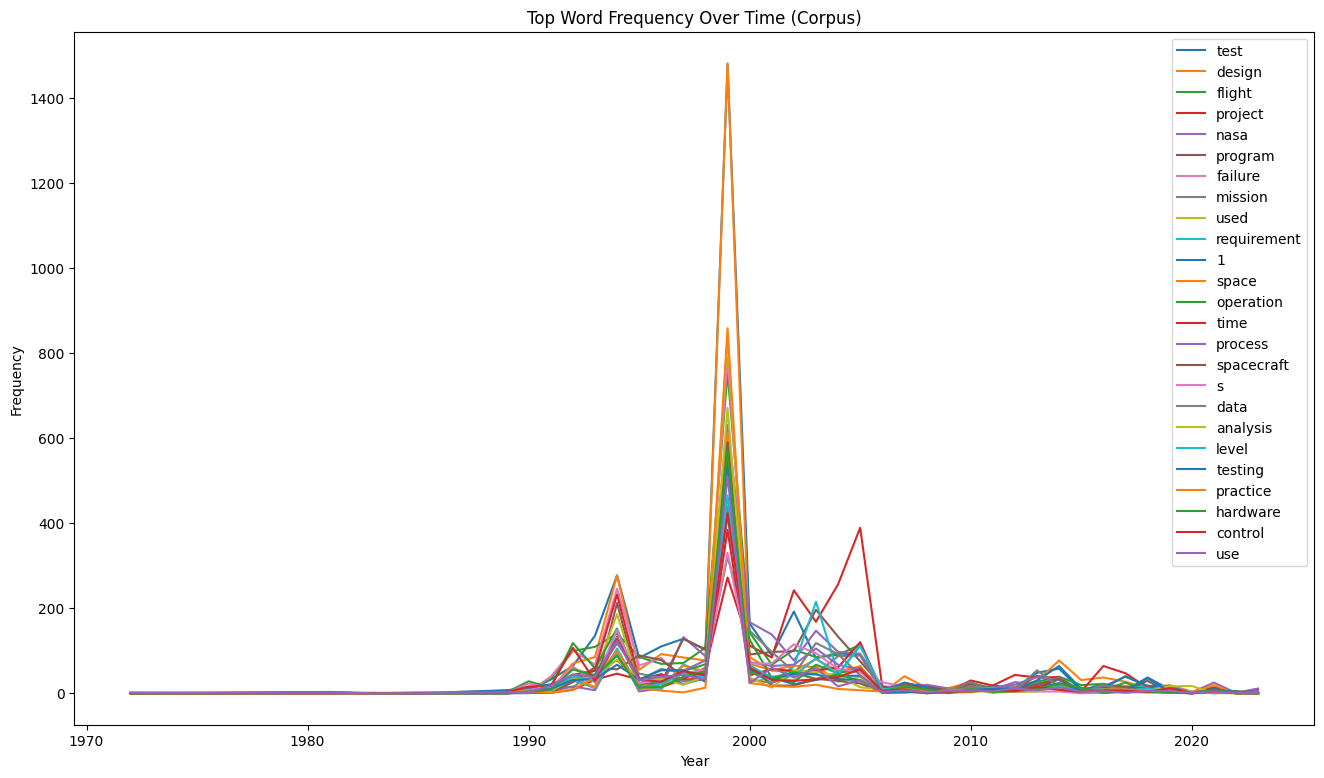

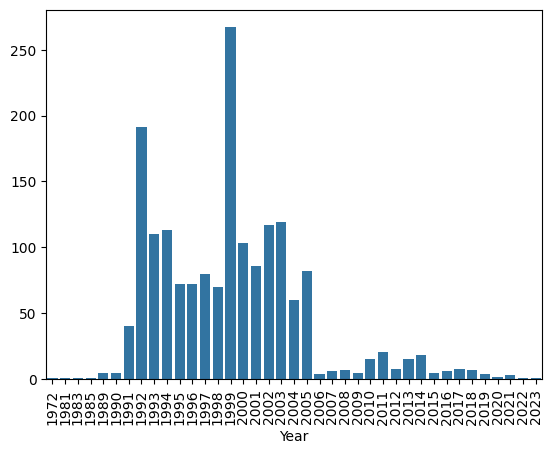

In [12]:
### MOST COMMON WORDS ###
number_of_words = 25

# Remove stop words and tokenize
def remove_stop_words(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

lessons_cleaned_data['Cleaned_Text'] = lessons_cleaned_data['Paragraph'].apply(remove_stop_words)

# Count word frequencies over time
lessons_cleaned_data['Year'] = pd.to_datetime(lessons_cleaned_data['Lesson_Date']).dt.year
word_counts = Counter()

for text in lessons_cleaned_data['Cleaned_Text']:
    word_counts.update(text)

# Get the top 10 words
top_words = [word for word, count in word_counts.most_common(number_of_words)]

# Prepare data for plotting
word_freq_over_time = {word: [] for word in top_words}
years = sorted(lessons_cleaned_data['Year'].unique())

for year in years:
    yearly_data = lessons_cleaned_data[lessons_cleaned_data['Year'] == year]
    yearly_word_counts = Counter()

    for text in yearly_data['Cleaned_Text']:
        yearly_word_counts.update(text)

    for word in top_words:
        word_freq_over_time[word].append(yearly_word_counts[word])

# Plot the data
plt.figure(figsize=(16, 9))
for word, freqs in word_freq_over_time.items():
    plt.plot(years, freqs, label=word)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Top Word Frequency Over Time (Corpus)')
plt.legend()
plt.show()

### HOW MANY ENTRIES PER YEAR? ###
# Ensure the 'Lesson_Date' column is in datetime format
lessons_cleaned_data['Lesson_Date'] = pd.to_datetime(lessons_cleaned_data['Lesson_Date'])

# Extract the year from the 'Lesson_Date' column
lessons_cleaned_data['Year'] = lessons_cleaned_data['Lesson_Date'].dt.year

# Group by the 'Year' column and count the number of rows for each year
rows_per_year = lessons_cleaned_data.groupby('Year').size()
rows_per_year_df = pd.DataFrame(rows_per_year)

### PLOT ENTIRES PER YEAR ###
sns.barplot(rows_per_year)
plt.xticks(rotation=90)
plt.show()

In [29]:
# Get the unique organizations
organizations = lessons_raw_data['Submitting_Organization'].unique()

# Define the number of top words you want
number_of_words = 10

organization_top_words_df = pd.DataFrame(columns=['Organization',f'Most Frequent {number_of_words} Words'])

# Loop through each organization and get the top n words
organization_top_words = {}

for organization in organizations:
    org_data = lessons_raw_data[lessons_raw_data['Submitting_Organization'] == organization]
    
    org_word_counts = Counter()
    
    for text in org_data['Cleaned_Text']:
        org_word_counts.update(text)
    
    top_words = [word for word, count in org_word_counts.most_common(number_of_words)]
    organization_top_words[organization] = top_words

list_of_orgs = []
list_of_top_words_per_org = []

# Collect the results
for organization, top_words in organization_top_words.items():
    list_of_orgs.append(organization)
    list_of_top_words_per_org.append(top_words)

organization_top_words_df = pd.DataFrame(data={'Organization':list_of_orgs, f'Most Frequent {number_of_words} Words':list_of_top_words_per_org}, columns=['Organization',f'Most Frequent {number_of_words} Words'])
organization_top_words_df

##################################################################################################################
# Plot bar charts for each organization
org_list = []
words_list = []


for organization, top_words in organization_top_words.items():
    word_freq = Counter([word for word in top_words])
    words, frequencies = zip(*word_freq.items())
#     print(organization, words)
    org_list.append(organization)
    words_list.append(words)

test_df = pd.DataFrame([org_list, words_list])
test_df[0]
    
#     plt.figure(figsize=(9, 16))
#     plt.bar(words, frequencies)
#     plt.xlabel('Words')
#     plt.ylabel('Frequency')
#     plt.title(f'Top {number_of_words} Words for {organization.upper()}')
#     plt.xticks(rotation=45)
#     plt.show()

0                                                  jsc
1    (test, design, failure, time, reliability, inv...
Name: 0, dtype: object

In [7]:
### TF-IDF Analysis ###

# Join the tokens back to string for TF-IDF and LDA
lessons_cleaned_data['Cleaned_Text_Str'] = lessons_cleaned_data['Cleaned_Text'].apply(lambda x: ' '.join(x))

# Loop through each organization and calculate TF-IDF
for organization in organizations:
    org_data = lessons_raw_data[lessons_raw_data['Submitting_Organization'] == organization]
    
    # Initialize TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=number_of_words)
    
    # Fit and transform the data
    tfidf_matrix = vectorizer.fit_transform(org_data['Cleaned_Text_Str'])
    
    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum TF-IDF scores for each word
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    tfidf_scores_dict = dict(zip(feature_names, tfidf_scores))
    
    # Sort and get top words
    top_words = sorted(tfidf_scores_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Display the results
    print(f"Top {number_of_words} words for {organization} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")
    print("\n")

### Topic Modeling (LDA) ###
# Define the number of topics and words
number_of_topics = 5

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Fit and transform the data
count_matrix = count_vectorizer.fit_transform(lessons_cleaned_data['Cleaned_Text_Str'])

# Initialize LDA
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=42)

# Fit the LDA model
lda.fit(count_matrix)

# Get the feature names (words)
feature_names = count_vectorizer.get_feature_names_out()

# Display the topics and their top words
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    top_features_indices = topic.argsort()[:-number_of_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_indices]
    top_features_scores = [topic[i] for i in top_features_indices]
    for word, score in zip(top_features, top_features_scores):
        print(f"{word}: {score:.4f}")
    print("\n")


Top 10 words for jsc based on TF-IDF:
investigation: 58.1965
test: 37.1974
failure: 31.9401
design: 27.3912
time: 24.1243
requirement: 22.5882
space: 20.6095
analysis: 18.3870
program: 15.4108
reliability: 9.8733


Top 10 words for ksc based on TF-IDF:
operation: 55.3115
failure: 49.7967
orbiter: 47.7225
design: 45.8409
control: 45.7785
used: 39.6274
equipment: 39.0300
program: 36.5568
time: 31.9700
power: 25.0265


Top 10 words for hq based on TF-IDF:
nasa: 56.3776
program: 48.8871
flight: 43.5180
space: 39.8850
safety: 34.9131
development: 30.2787
process: 27.9902
operation: 27.8811
plan: 26.7276
training: 20.9479


Top 10 words for afrc based on TF-IDF:
aircraft: 5.7010
flight: 5.4336
power: 5.0231
actuator: 4.3648
main: 3.1060
rocket: 2.7660
test: 2.6086
wing: 2.3920
pressure: 2.3869
chute: 0.9750


Top 10 words for jpl based on TF-IDF:
test: 95.9436
design: 87.1587
spacecraft: 81.4020
flight: 71.6565
mission: 68.0431
jpl: 62.7864
failure: 60.3518
project: 52.1925
practice: 45.5892

In [10]:
# Load data
data = lessons_cleaned_data
# Initialize BERTopic for topic modeling
topic_model = BERTopic()
topics, _ = topic_model.fit_transform(data['Paragraph'])

# Add topics to the DataFrame
data['Topic'] = topics

# Initialize sentiment analysis model and tokenizer
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

def analyze_sentiment(text, max_length=512):
    # Tokenize and truncate the text to the maximum length
    tokens = tokenizer(text, max_length=max_length, truncation=True, return_tensors='pt')
    # Decode the truncated tokens back to text
    truncated_text = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True)
    # Analyze sentiment
    result = sentiment_analyzer(truncated_text)
    return result[0]['label']

data['Sentiment'] = data['Paragraph'].apply(analyze_sentiment)

# Load spaCy model and add PyTextRank
nlp = spacy.load("en_core_web_trf")
if 'textrank' not in nlp.pipe_names:
    nlp.add_pipe("textrank")

def summarize_text(text, nlp):
    doc = nlp(text)
    summary = " ".join([sent.text for sent in doc._.textrank.summary(limit_sentences=3)])
    return summary

data['Summary'] = data['Paragraph'].apply(lambda x: summarize_text(x, nlp))

# Display the resulting DataFrame
data.head()

# # Optional: Save the results to a CSV file for further analysis or reporting
# data.to_csv('processed_lessons_data.csv', index=False)

,URL,Paragraph,Lesson_Number,Lesson_Date,Submitting_Organization,Cleaned_Text,Year,Cleaned_Text_Str,Topic,Sentiment,Summary
0,https://llis.nasa.gov/lesson/1,prelaunch check shuttle orbiter ov-104 flight ...,1,1991-04-09,jsc,"[prelaunch, check, shuttle, orbiter, ov, 104, ...",1991,prelaunch check shuttle orbiter ov 104 flight ...,-1,NEGATIVE,vendor ' inspection failed inverter found loos...
1,https://llis.nasa.gov/lesson/10,shuttle orbiter general purpose computer ( gpc...,10,1991-06-17,jsc,"[shuttle, orbiter, general, purpose, computer,...",1991,shuttle orbiter general purpose computer gpc i...,-1,NEGATIVE,computer exchanged computer connected iop no.2...
2,https://llis.nasa.gov/lesson/100,two employee received caustic electrolyte expo...,100,1992-08-07,ksc,"[employee, received, caustic, electrolyte, exp...",1992,employee received caustic electrolyte exposure...,-1,NEGATIVE,use battery completed qualification testing ca...
3,https://llis.nasa.gov/lesson/1000,leaking reaction control system ( rcs ) thrust...,1000,1997-02-01,hq,"[leaking, reaction, control, rcs, thruster, va...",1997,leaking reaction control rcs thruster valve or...,-1,NEGATIVE,leaking reaction control system ( rcs ) thrust...
4,https://llis.nasa.gov/lesson/10001,accelerated schedule osp program necessitated ...,10001,2014-08-11,ksc,"[accelerated, schedule, osp, program, necessit...",2014,accelerated schedule osp program necessitated ...,4,NEGATIVE,failure fully staff requirement development te...
